## 02_feature_engineering.ipynb

This notebook performs **feature engineering** and **correlation-based feature selection** on the cleaned CIC-IIoT dataset.
It aims to improve model performance by reducing redundancy, standardizing features, and preserving the most informative dimensions.


#### Import Libraries

In [66]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA


#### Paths

In [67]:
DATA_DIR = os.path.join("data", "merged")
FEATURE_DIR = os.path.join("data", "features")
os.makedirs(FEATURE_DIR, exist_ok=True)

#### Load & Seperate

In [68]:
# Load cleaned dataset
df = pd.read_csv(os.path.join(DATA_DIR, "combined_balanced_cleaned.csv"))
print(f"Loaded cleaned dataset → {df.shape[0]:,} rows × {df.shape[1]} columns")

# Separate labels and features
label_cols = ["label1", "label2", "label3", "label4", "label_full"]
labels_df = df[label_cols]
X = df.drop(columns=label_cols)

Loaded cleaned dataset → 70,000 rows × 73 columns


#### Feature Overview & Statistics

Number of numeric columns: 53
Number of categorical columns: 15


,Non-Null Count,Unique Count,Data Type
timestamp,70000,45167,object
timestamp_start,70000,28072,object
timestamp_end,70000,28575,object
log_data-ranges_avg,70000,2221,float64
log_data-ranges_max,70000,435,float64
log_data-ranges_min,70000,407,float64
log_data-ranges_std_deviation,70000,3034,float64
log_interval-messages,70000,1675,float64
log_messages_count,70000,109,int64
network_fragmentation-score,70000,197,float64


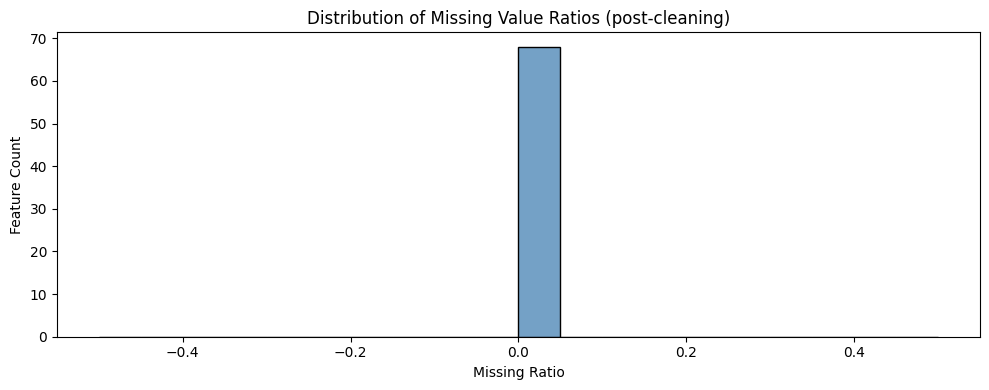

In [69]:
# Basic stats
print("Number of numeric columns:", X.select_dtypes(include=["number"]).shape[1])
print("Number of categorical columns:", X.select_dtypes(exclude=["number"]).shape[1])

# Feature summary
feature_summary = pd.DataFrame({
    "Non-Null Count": X.notnull().sum(),
    "Unique Count": X.nunique(),
    "Data Type": X.dtypes
}).sort_values(by="Non-Null Count", ascending=False)

display(feature_summary.head(10))

# Quick visualization of missing ratios (sanity check)
missing_ratio = X.isnull().mean().sort_values(ascending=False)
plt.figure(figsize=(10,4))
sns.histplot(missing_ratio, bins=20, kde=False, color="steelblue")
plt.title("Distribution of Missing Value Ratios (post-cleaning)")
plt.xlabel("Missing Ratio")
plt.ylabel("Feature Count")
plt.tight_layout()
plt.show()

#### Correlation Analysis

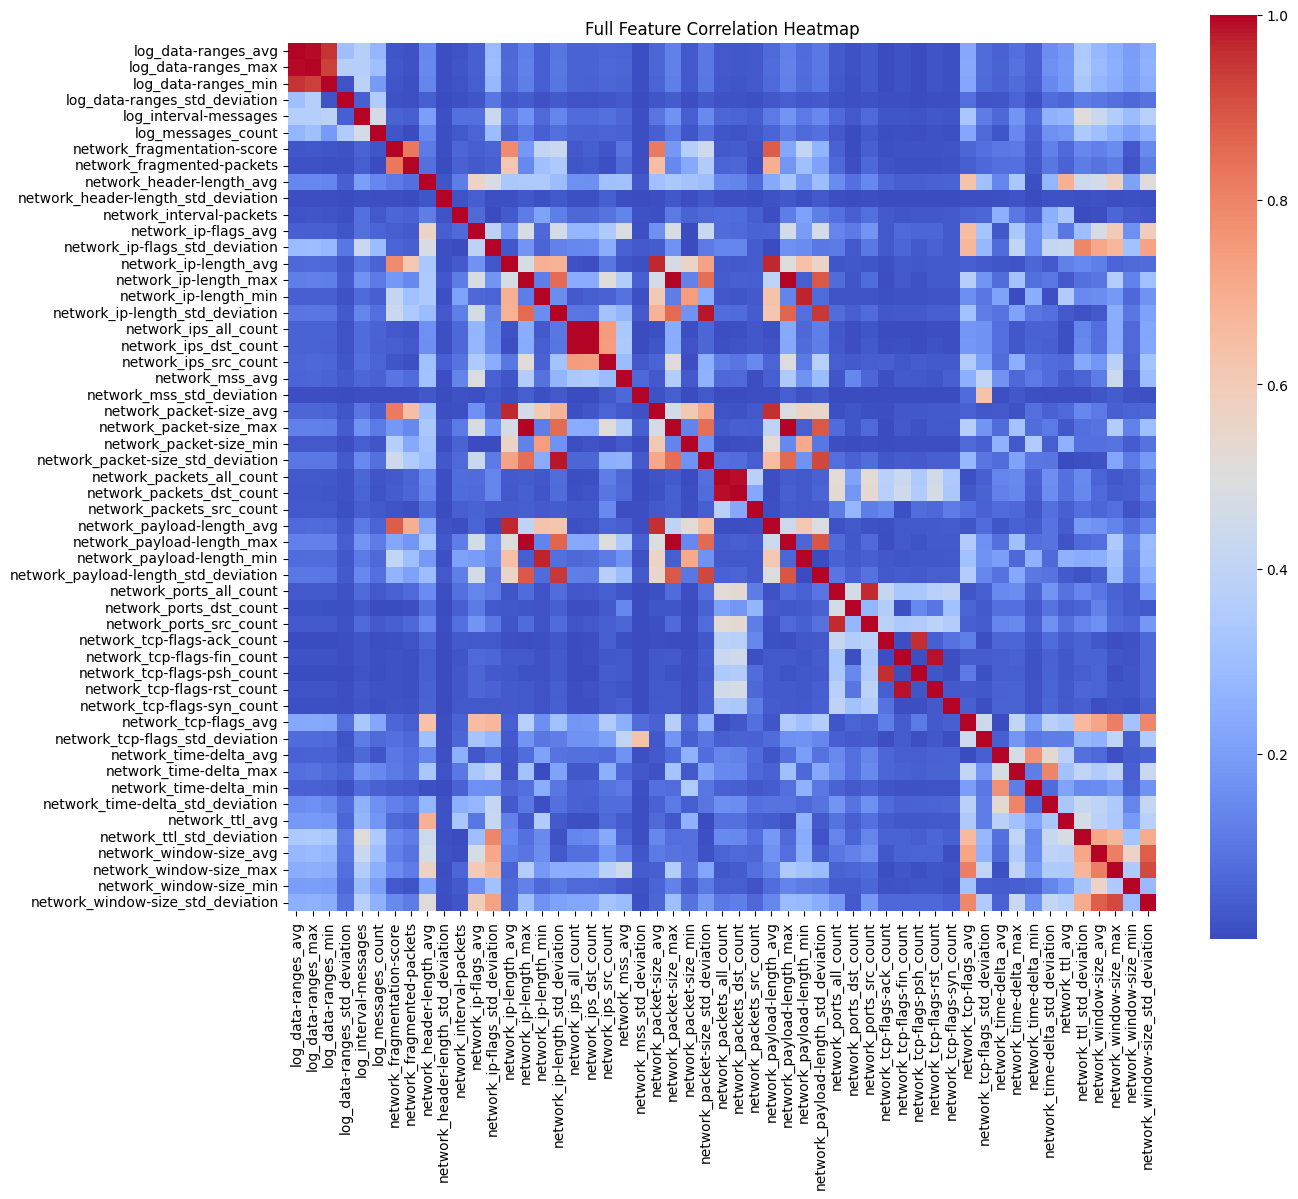

→ Found 13 highly correlated features (|corr| > 0.95)
   Example: ['log_data-ranges_max', 'log_data-ranges_min', 'network_ips_dst_count', 'network_packet-size_avg', 'network_packet-size_max', 'network_packet-size_std_deviation', 'network_packets_dst_count', 'network_payload-length_avg', 'network_payload-length_max', 'network_payload-length_min'] ...
 Remaining features after correlation filtering: 55


In [70]:
# Compute full correlation matrix (numeric-only)
numeric_cols = X.select_dtypes(include=["number"]).columns
corr_matrix = X[numeric_cols].corr().abs()

# Visualize full heatmap (use smaller figure size only if too big)
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, cmap="coolwarm", square=True, cbar=True)
plt.title("Full Feature Correlation Heatmap")
plt.show()

# Identify highly correlated feature pairs (threshold > 0.95)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_cols = [col for col in upper_tri.columns if any(upper_tri[col] > 0.95)]

print(f"→ Found {len(high_corr_cols)} highly correlated features (|corr| > 0.95)")
if len(high_corr_cols) > 0:
    print(f"   Example: {high_corr_cols[:10]} ...")

# Drop them from X
X.drop(columns=high_corr_cols, inplace=True)
print(f" Remaining features after correlation filtering: {X.shape[1]}")


#### Encoding Categorical Features

In [71]:
cat_cols = X.select_dtypes(exclude=["number"]).columns
low_card_cols = [c for c in cat_cols if X[c].nunique() <= 20]  
high_card_cols = [c for c in cat_cols if X[c].nunique() > 20]

print(f"Low-cardinality columns to encode: {low_card_cols}")
print(f"Skipping high-cardinality columns: {high_card_cols[:5]} ... ({len(high_card_cols)} total)")

if len(low_card_cols) > 0:
    X = pd.get_dummies(X, columns=low_card_cols, drop_first=True)
else:
    print("No low-cardinality categorical columns detected.")

Low-cardinality columns to encode: []
Skipping high-cardinality columns: ['timestamp', 'timestamp_start', 'timestamp_end', 'network_ips_all', 'network_ips_dst'] ... (15 total)
No low-cardinality categorical columns detected.


#### Feature Scaling

In [72]:
non_numeric = X.select_dtypes(exclude=["number"]).columns
if len(non_numeric) > 0:
    print(f"Dropping {len(non_numeric)} non-numeric columns before scaling:")
    print(list(non_numeric)[:10])
    X = X.drop(columns=non_numeric)


scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print("Scaled feature mean (avg):", round(X_scaled.mean().mean(), 3))
print("Scaled feature std (avg):", round(X_scaled.std().mean(), 3))


Dropping 15 non-numeric columns before scaling:
['timestamp', 'timestamp_start', 'timestamp_end', 'network_ips_all', 'network_ips_dst', 'network_ips_src', 'network_macs_all', 'network_macs_dst', 'network_macs_src', 'network_ports_all']
Scaled feature mean (avg): -0.0
Scaled feature std (avg): 1.0


#### Dimensionality Reduction with PCA (Principal Component Analysis)

Original features: 40
PCA-reduced features: 25
Variance explained by 25 components: 0.9525


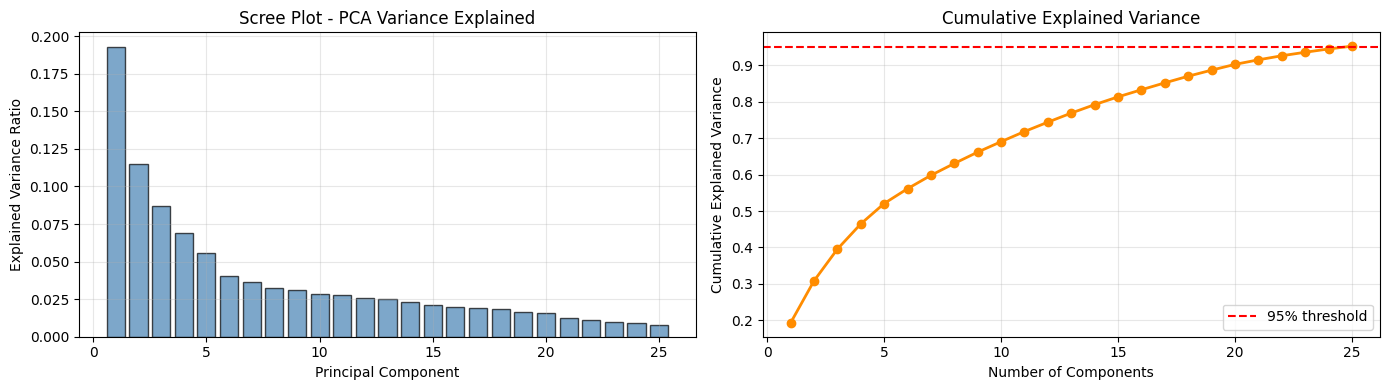


PCA component shape: (70000, 25)


In [73]:
# Apply PCA - retain 95% of variance
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"Original features: {X_scaled.shape[1]}")
print(f"PCA-reduced features: {X_pca.shape[1]}")
print(f"Variance explained by {X_pca.shape[1]} components: {pca.explained_variance_ratio_.sum():.4f}")

# Visualize explained variance
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Scree plot
axes[0].bar(range(1, len(pca.explained_variance_ratio_)+1), 
            pca.explained_variance_ratio_, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].set_xlabel("Principal Component")
axes[0].set_ylabel("Explained Variance Ratio")
axes[0].set_title("Scree Plot - PCA Variance Explained")
axes[0].grid(alpha=0.3)

# Cumulative explained variance
cumsum = np.cumsum(pca.explained_variance_ratio_)
axes[1].plot(range(1, len(cumsum)+1), cumsum, marker='o', color='darkorange', linewidth=2)
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
axes[1].set_xlabel("Number of Components")
axes[1].set_ylabel("Cumulative Explained Variance")
axes[1].set_title("Cumulative Explained Variance")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Create DataFrame with PCA components
X_pca_df = pd.DataFrame(X_pca, columns=[f"PC_{i+1}" for i in range(X_pca.shape[1])])
print(f"\nPCA component shape: {X_pca_df.shape}")


In [76]:
engineered_df = pd.concat([X_pca_df, labels_df.reset_index(drop=True)], axis=1)
print(f"Final engineered dataset shape (with PCA): {engineered_df.shape}")
print(f"Dimensionality reduction: {X_scaled.shape[1]} → {X_pca_df.shape[1]} features")
engineered_path = os.path.join(FEATURE_DIR, "combined_engineered_balanced_features.csv")
engineered_df.to_csv(engineered_path, index=False)
print(f"\nPCA-reduced feature-engineered dataset saved at: {engineered_path}")

Final engineered dataset shape (with PCA): (70000, 30)
Dimensionality reduction: 40 → 25 features

PCA-reduced feature-engineered dataset saved at: data\features\combined_engineered_balanced_features.csv
